Projekt wykorzystuje podstawowe modele uczenia maszynowego do przewidywania reakcji opinii publicznej na posty umieszczane na Twitterze.

### Spis treści

1. Wstępna obróbka danych:

 - załadowanie zbióru treningowego i testowego,
 - usunięcie wierszy o brakujących elementach,
 - w kolumnie `sentiment` zmiana wartości `'Irrelevant'` na `'Neutral'`.

1. Wizualizacja danych:

 - histogram tematów twittów (`entity`),
 - histogram nastawień (`sentiment`),
 - najczęściej padających słów w treści twittów (`content`).

1. Przygotowanie danych:

 - wektoryzacje kolumny `content`, 
 - przygotowanie etykiety poprzez zakodowanie tekstowych wartości w kolumnie `sentiment` do postaci liczbowej.

  - Uczenie naiwnego modelu bayesowskiego. Sprawdzenie działania modelu na własnoręcznie napisanej wiadomości. 

1. Trenowanie innych modeli:
 - liniowy SVM,
 - regresji logistycznej,
 - drzewo decyzyjne.

  - Sprawdzenie modeli na danych treningowych (walidacja krzyżowa) i testowych.
  
1. Zespół ekspertów ręcznie klasyfikuje dane z dokładnością 95%. Porównanie wyników modelu z pracą ekspertów.

### Zbiór danych

Zbiór danych został przygotowany na podstawie zbioru [Twitter Sentiment Analysis](https://www.kaggle.com/jp797498e/twitter-entity-sentiment-analysis) i składa się z dwóch plików:
-  `twitter_training.csv` - zbiór treningowy,
- `twitter_validation.csv` - zbiór testowy.

Archiwum z plikami można pobrać z [dysku google](https://drive.google.com/file/d/1sw2vA87fmAI5V5Xl9k-PCSdN5XwydhOB/view?usp=sharing) lub odkomentowując poniższe linie:

In [ ]:
! pip install gdown
! gdown https://drive.google.com/uc?id=1sw2vA87fmAI5V5Xl9k-PCSdN5XwydhOB
! unzip twitter.zip

Downloading...
From: https://drive.google.com/uc?id=1sw2vA87fmAI5V5Xl9k-PCSdN5XwydhOB
To: /content/twitter.zip
100% 2.07M/2.07M [00:00<00:00, 64.7MB/s]
Archive:  twitter.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


## Rozwiązanie

# Instalacja potrzebnych bibliotek i funkcji

In [ ]:
!pip3 install nltk
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip3 install wordcloud
import wordcloud
from wordcloud import WordCloud

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import tree, preprocessing
from sklearn.svm import LinearSVC
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

# Wczytanie danych 

In [ ]:
df = pd.read_csv('twitter_training.csv', encoding='latin-1')
df_test = pd.read_csv('twitter_validation.csv', encoding='latin-1')

In [ ]:
df

,id,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
df_test

,id,entity,sentiment,content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,â­ï¸ Toronto is the arts and culture capital...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so itâs time to drink wine n pl...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


# Wstępna obróbka danych

In [ ]:
df['content'].replace('  ', np.nan, inplace=True)
df = df.dropna()

In [ ]:
df["sentiment"] = df["sentiment"].replace({"Irrelevant": "Neutral"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test["sentiment"] = df_test["sentiment"].replace({"Irrelevant": "Neutral"})

# Wizualizacja danych

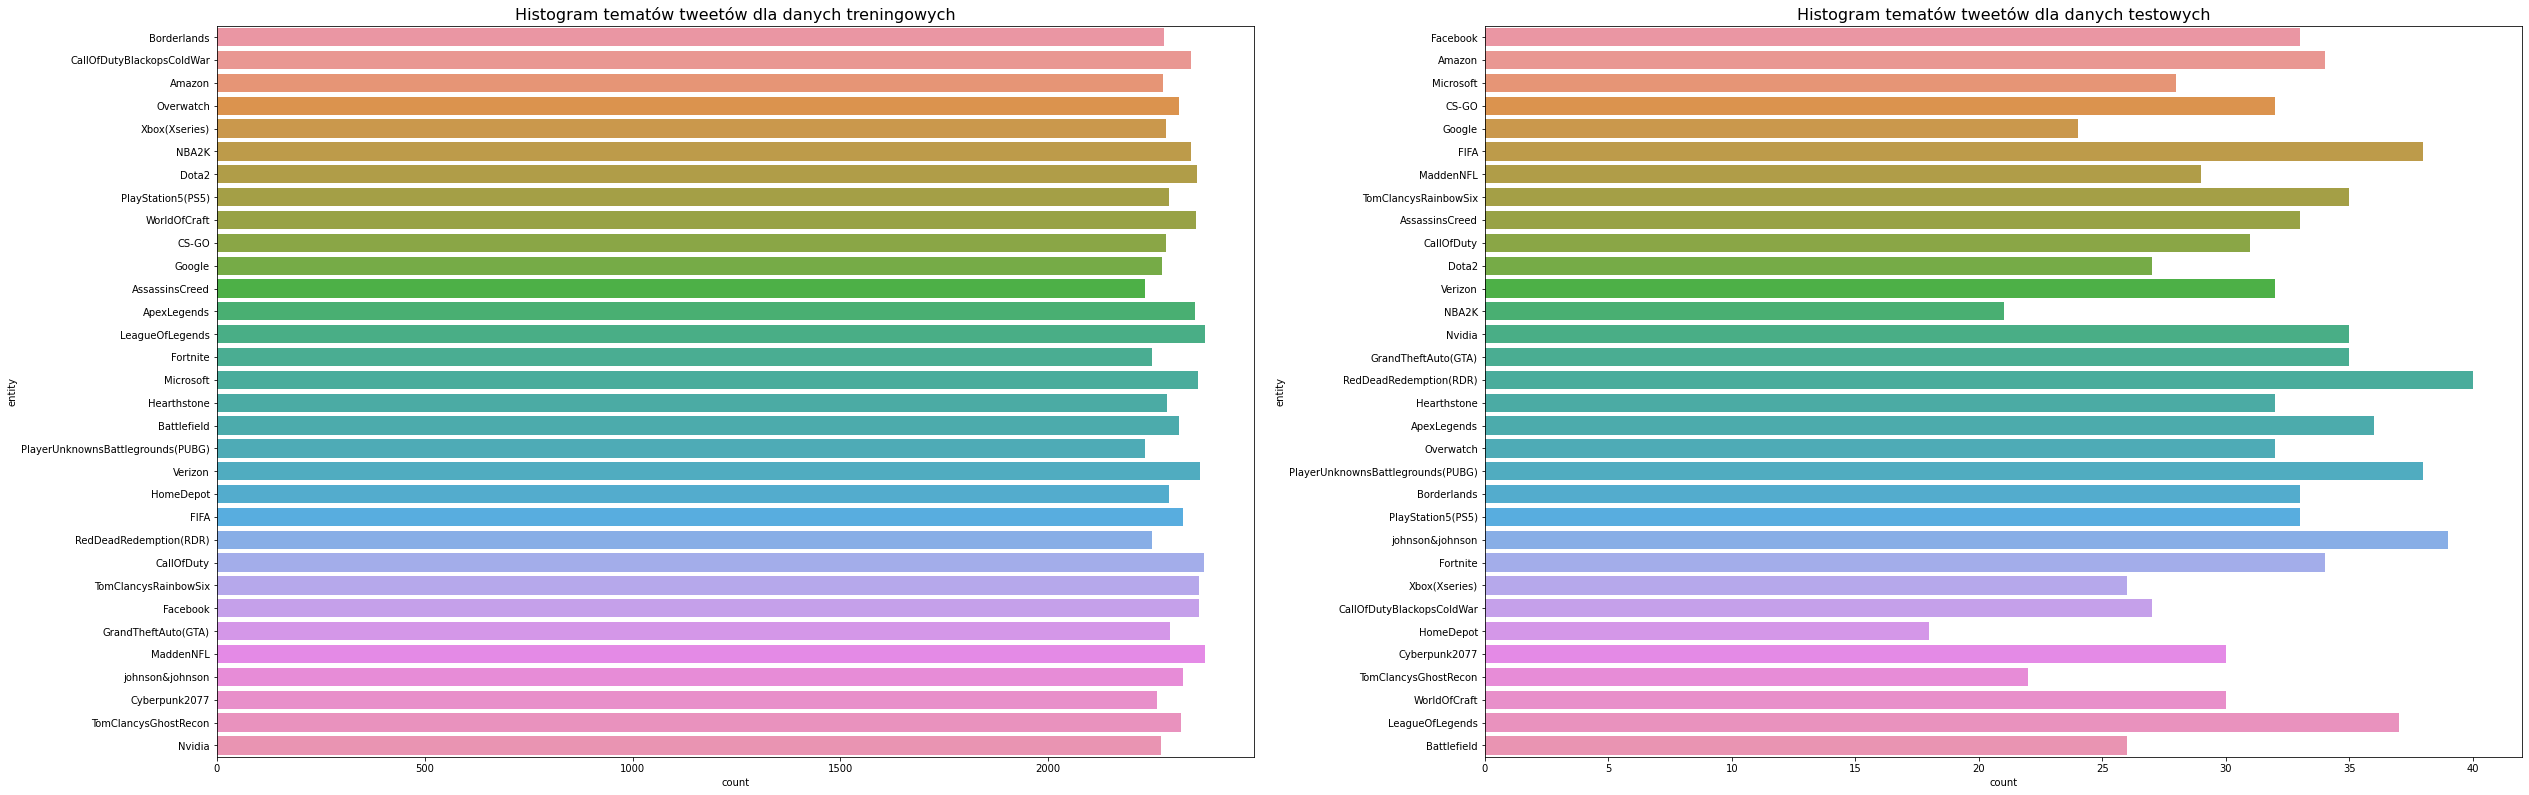

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (38,16))
fig.tight_layout(pad = 20)
ax[0].set_title('Histogram tematów tweetów dla danych treningowych', fontsize = 16)
sns.countplot(y="entity", data=df, ax = ax[0])
ax[1].set_title('Histogram tematów tweetów dla danych testowych', fontsize = 16)
sns.countplot(y="entity", data=df_test, ax = ax[1])

Text(0.5, 1.0, 'Histogram nastawień dla danych testowych')

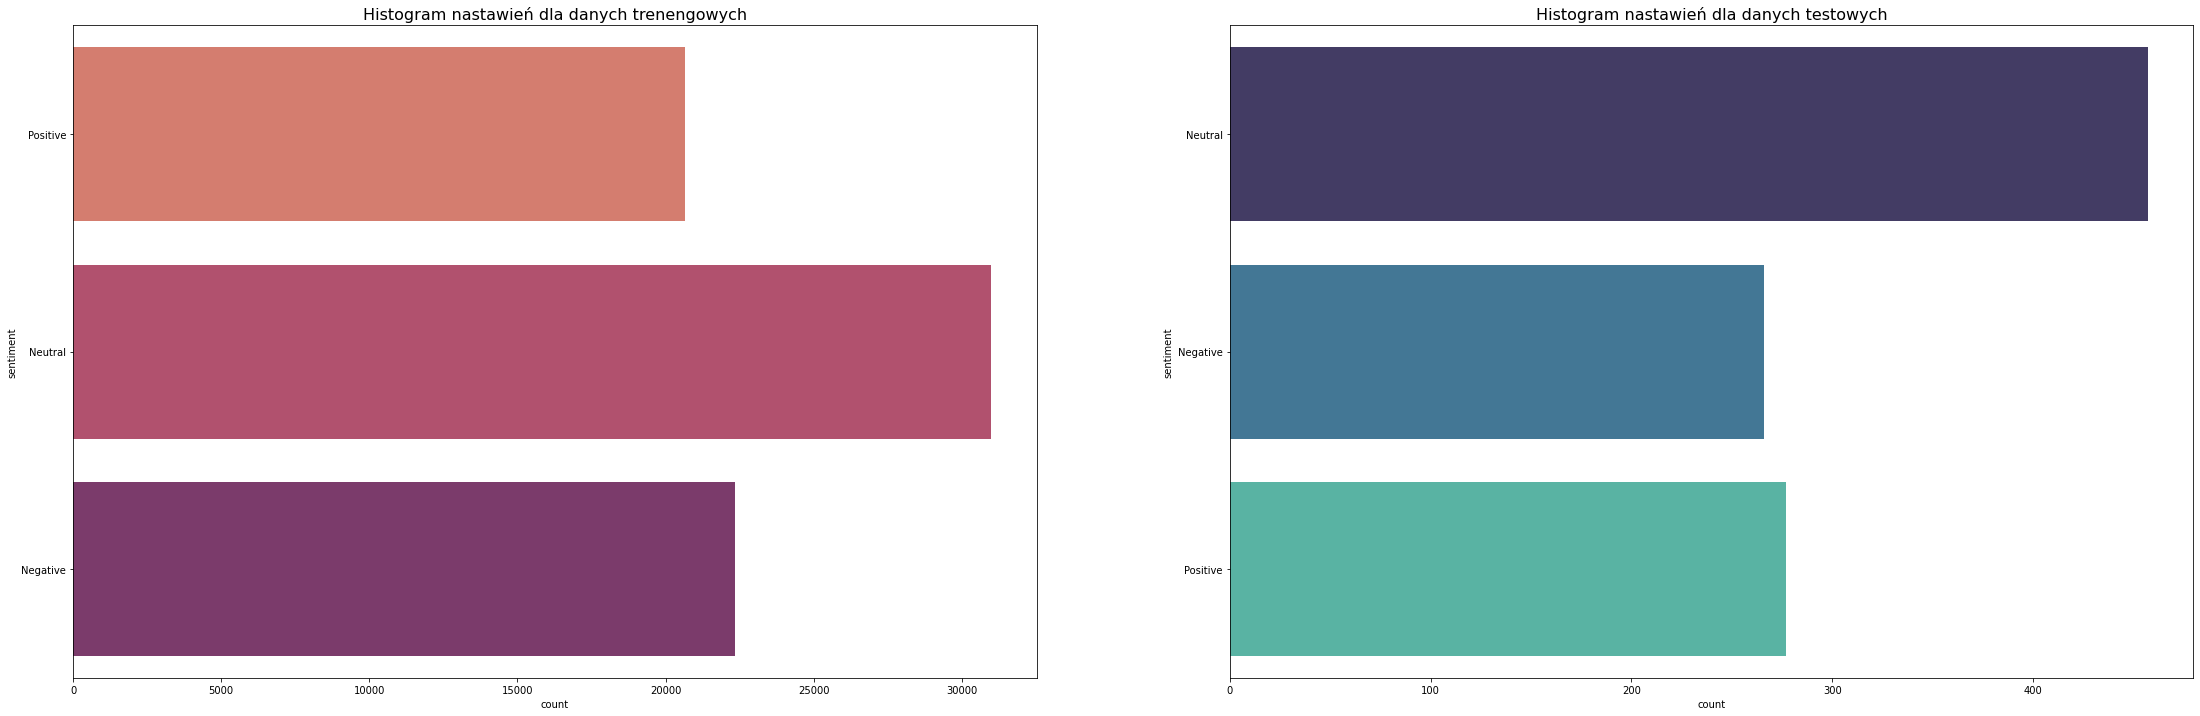

In [ ]:
plt.figure(figsize=(38,12))
plt.subplot(1,2,1)
sns.countplot(y="sentiment", data=df, palette="flare")
plt.title('Histogram nastawień dla danych trenengowych', fontsize = 16)
plt.subplot(1,2,2)
sns.countplot(y="sentiment", data=df_test, palette="mako")
plt.title('Histogram nastawień dla danych testowych', fontsize = 16)

Dane są nieznacznie niezbalansowane. Nie powinno to mieć dużego, negatywnego wpływu na nasze modele.

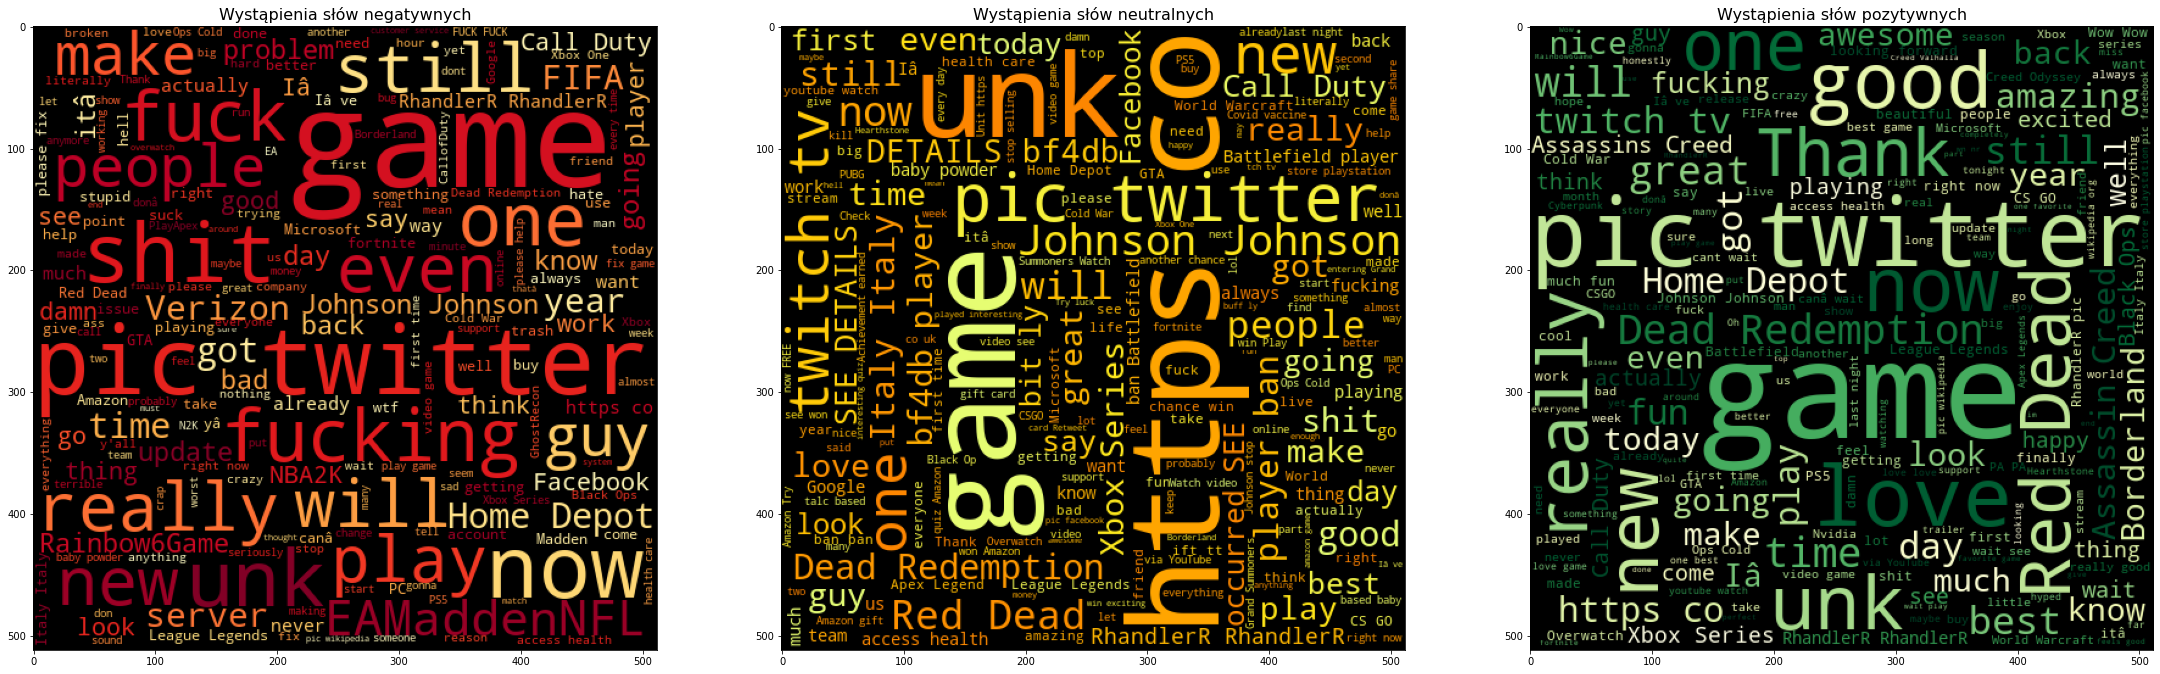

In [ ]:
negative_words = " ".join(list(df [df['sentiment']=='Negative']['content'] ))
negative_plot = WordCloud(width = 512, height = 512).generate(negative_words)

neutral_words = " ".join(list(df [df['sentiment']=='Neutral']['content'] ))
neutral_plot = WordCloud(width = 512, height = 512).generate(neutral_words)

positive_words = " ".join(list(df [df['sentiment']=='Positive']['content'] ))
positive_plot = WordCloud(width = 512, height = 512).generate(positive_words)

plt.figure(figsize=(38,12))

plt.subplot(1,3,1)
plt.title('Wystąpienia słów negatywnych', fontsize = 16)
plt.imshow(negative_plot.recolor(colormap='YlOrRd'));

plt.subplot(1,3,2)
plt.title('Wystąpienia słów neutralnych', fontsize = 16)
plt.imshow(neutral_plot.recolor(colormap='Wistia'));

plt.subplot(1,3,3)
plt.title('Wystąpienia słów pozytywnych', fontsize = 16)
plt.imshow(positive_plot.recolor(colormap='YlGn'));

# Dalsza obróbka danych
* Zmiana nastawień z napisów na liczby, gdzie 1 to neutral, 2 to positive a 0 to negative.
* Wektoryzacja kolumny z treścią tweetów.

In [ ]:
df['sentiment'] =  pd.factorize(df['sentiment'], sort = True)[0]
df_test['sentiment'] = pd.factorize(df_test['sentiment'], sort = True)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(analyzer=stemmed_words)

In [ ]:
text = df['content']
text_transformed = vectorizer.fit_transform(text)

In [ ]:
text_test = df_test['content']
text_transformed_test = vectorizer.transform(text_test)

# Uczenie modeli


Zdefiniowanie zbioru uczącego i testowego.

In [ ]:
X_train = text_transformed
y_train = df['sentiment']
X_test = text_transformed_test
y_test = df_test['sentiment']

Naiwny model Bayesowski

In [ ]:
model_clf = MultinomialNB()
model_clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
ppv = cross_val_score(model_clf, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(model_clf, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model_clf, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model_clf, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.51 +/- 0.05
REC = 0.51 +/- 0.05
ACC = 0.51 +/- 0.05
F1 = 0.51 +/- 0.05


In [ ]:
y_pred_clf_test = model_clf.predict(X_test)

In [ ]:
print('\n\nDla zbioru testowego:\n')
print('Raport klasyfikacji:\n', metrics.classification_report(y_test, y_pred_clf_test))
print('Macierz błędów:\n', metrics.confusion_matrix(y_test, y_pred_clf_test))
print('\nMCC: ', metrics.matthews_corrcoef(y_test, y_pred_clf_test))



Dla zbioru testowego:

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.73      0.87      0.79       266
           1       0.91      0.75      0.82       457
           2       0.78      0.86      0.82       277

    accuracy                           0.81      1000
   macro avg       0.81      0.83      0.81      1000
weighted avg       0.82      0.81      0.81      1000

Macierz błędów:
 [[231  15  20]
 [ 67 343  47]
 [ 19  20 238]]

MCC:  0.7198244194817511


Sprawdzenie, które słowa mogą sprawić, że wypowiedź zostanie zakwalifikowana jako negatywna.

In [ ]:
feature_names = vectorizer.get_feature_names()
feature_names = np.array(feature_names)
coeff = model_clf.coef_[0]
top10 = np.argsort(coeff)[-10:]
bottom10 = np.argsort(coeff)[:10]

print("Słowa, które z największą pewnością wskazują maszynie, że wypowiedź jest negatywna:")
print(feature_names[top10])

print("Słowa najmniej istotne przy klasyfikacji:")
print(feature_names[bottom10])

Słowa, które z największą pewnością wskazują maszynie, że wypowiedź jest negatywna:
['game' 'you' 'in' 'thi' 'of' 'it' 'is' 'and' 'to' 'the']
Słowa najmniej istotne przy klasyfikacji:
['kamen' 'miepxudza4' 'mie' 'midwestern' 'midnddddd' 'midndddd'
 'midgamecrisi' 'mifec3dmh5' 'midgamecon' 'midday']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


Sprawdzenie działania modelu na subiektywnie miłym, pozytywnym zdaniu.

In [ ]:
message = ['Lets play together']
message_transformed = vectorizer.transform(message)
result = model_clf.predict(message_transformed)
print(result[0])
if result[0] == 0:
  result = 'negative'
if result[0] == 1:
  result = 'neutral'
if result[0] == 2:
  result = 'positive'

print("Model result for senstence: \n {} is {}".format(message,result))

2
Model result for senstence: 
 ['Lets play together'] is positive


Model regresji logistycznej

In [ ]:
model_regresja = LogisticRegression(solver = 'liblinear', max_iter=3000)
model_regresja.fit(X_train, y_train)

LogisticRegression(max_iter=3000, solver='liblinear')

In [ ]:
ppv = cross_val_score(model_regresja, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(model_regresja, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model_regresja, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model_regresja, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.51 +/- 0.05
REC = 0.51 +/- 0.05
ACC = 0.51 +/- 0.05
F1 = 0.51 +/- 0.05


In [ ]:
y_pred_regresja_test = model_regresja.predict(X_test)

In [ ]:
print('\n\nDla zbioru testowego:\n')
print('Raport klasyfikacji:\n', metrics.classification_report(y_test, y_pred_regresja_test))
print('Macierz błędów:\n', metrics.confusion_matrix(y_test, y_pred_regresja_test))
print('\nMCC: ', metrics.matthews_corrcoef(y_test, y_pred_regresja_test))



Dla zbioru testowego:

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       266
           1       0.94      0.93      0.94       457
           2       0.90      0.92      0.91       277

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

Macierz błędów:
 [[250   6  10]
 [ 15 425  17]
 [  2  20 255]]

MCC:  0.8914760329396598


Model drzewa decyzyjnego

In [ ]:
model_tree = tree.DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
ppv = cross_val_score(model_tree, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(model_tree, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model_tree, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model_tree, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.45 +/- 0.03
REC = 0.45 +/- 0.03
ACC = 0.45 +/- 0.04
F1 = 0.45 +/- 0.04


In [ ]:
y_pred_tree_test = model_tree.predict(X_test)

In [ ]:
print('\n\nDla zbioru testowego:\n')
print('Raport klasyfikacji:\n', metrics.classification_report(y_test, y_pred_tree_test))
print('Macierz błędów:\n', metrics.confusion_matrix(y_test, y_pred_tree_test))
print('\nMCC: ', metrics.matthews_corrcoef(y_test, y_pred_tree_test))



Dla zbioru testowego:

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       266
           1       0.92      0.92      0.92       457
           2       0.90      0.90      0.90       277

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Macierz błędów:
 [[247  15   4]
 [ 12 421  24]
 [  5  22 250]]

MCC:  0.8725688557567869


Model liniowy SVM

In [ ]:
model_SVC = LinearSVC(dual = False, max_iter = 4000)
model_SVC.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=4000)

In [ ]:
ppv = cross_val_score(model_SVC, X_train, y_train, cv=5, scoring='precision_micro')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(model_SVC, X_train, y_train, cv=5, scoring='recall_micro')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model_SVC, X_train, y_train, cv=5, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model_SVC, X_train, y_train, cv=5, scoring='f1_micro')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.48 +/- 0.05
REC = 0.48 +/- 0.05
ACC = 0.48 +/- 0.05
F1 = 0.48 +/- 0.05


In [ ]:
y_pred_SVC_test = model_SVC.predict(X_test)

In [ ]:
print('\n\nDla zbioru testowego:\n')
print('Raport klasyfikacji:\n', metrics.classification_report(y_test, y_pred_SVC_test))
print('Macierz błędów:\n', metrics.confusion_matrix(y_test, y_pred_SVC_test))
print('\nMCC: ', metrics.matthews_corrcoef(y_test, y_pred_SVC_test))



Dla zbioru testowego:

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       266
           1       0.95      0.95      0.95       457
           2       0.93      0.93      0.93       277

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000

Macierz błędów:
 [[252   7   7]
 [ 10 434  13]
 [  3  16 258]]

MCC:  0.9129982880586919


Najwiekszą dokładnością dla danych testowych wykazał się model liniowy SVM. Porównując jego dokładność na poziomie 94% z dokładnością ręcznej kwalifikacji przez ekspertów równą 95% można śmiało powiedzieć, że bardziej opłaca się korzystanie z maszyny. Zatrudnienie ekspertów jest bardziej kosztowne niż uruchomienie algorytmu. Ponad to pracownicy robiący to ręcznie są dużo wolniejsi od komputera, który trenuje model w ciagu minuty. W związku z tym różnica 1% dokładności nie jest dużą stratą w perspektynie tańszego i szybszego rozwiązania.